In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import json
import matplotlib
import os
import random
import torch

from collections import Counter, defaultdict
from itertools import islice
from sklearn.utils import shuffle
from tqdm import tqdm, trange
from torch.optim import Adam
from torch.utils.data import TensorDataset

from models.Encoder import *
from models.Decoder import *
from models.utils import *
from utils import *

# set fixed random seed to reproduce results
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

%matplotlib inline

GPU is available
GPU is available


Using TensorFlow backend.


# Experiment 2

In [2]:
# define experiment
exp='/exp_2'

# define number of iterations
n_iters = 20000

# define batch size
batch_size = 32

In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# load dataset into memory, and get w2idx, idx2w, w2freq dictionaries and lists of input and output sentences
cmd_vocab, w2i_cmds, i2w_cmds, cmds_train, act_vocab, w2i_acts, i2w_acts, acts_train = load_dataset(exp=exp, split='/train')
_, _, _, cmds_test, _, _, _, acts_test = load_dataset(exp=exp, split='/test')

In [5]:
## create input and output language pairs ##

# training
train_cmd_act_pairs = create_pairs(cmds_train, acts_train)
print("Number of train source-target pairs: {}".format(len(train_cmd_act_pairs)))

# testing
test_cmd_act_pairs = create_pairs(cmds_test, acts_test)
print("Number of test source-target pairs: {}".format(len(test_cmd_act_pairs)))

Number of train source-target pairs: 16990
Number of test source-target pairs: 3920


In [6]:
# show random train command-action pair
random_pair = random.choice(train_cmd_act_pairs)
print("Command: {}".format(random_pair[0]))
print("Action: {}".format(random_pair[1]))

Command: ['jump', 'opposite', 'left', 'after', 'run', 'thrice']
Action: ['I_RUN', 'I_RUN', 'I_RUN', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_JUMP']


In [7]:
# show random test command-action pair
random_pair = random.choice(test_cmd_act_pairs)
print("Command: {}".format(random_pair[0]))
print("Action: {}".format(random_pair[1]))

Command: ['run', 'around', 'right', 'twice', 'and', 'look', 'around', 'right']
Action: ['I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_LOOK', 'I_TURN_RIGHT', 'I_LOOK', 'I_TURN_RIGHT', 'I_LOOK', 'I_TURN_RIGHT', 'I_LOOK']


## Prepare data

In [8]:
cmds_train, acts_train, input_lengths_train, masks = pairs2idx(cmds_train, acts_train, w2i_cmds, w2i_acts, padding=True, training=True)
cmds_test, acts_test, input_lengths_test = pairs2idx(cmds_test, acts_test, w2i_cmds, w2i_acts, padding=True, training=False)

In [9]:
# create train and test data loaders
train_dl = create_batches(cmds_train, acts_train, input_lengths_train, batch_size=batch_size, masks=masks, split='train', num_samples=n_iters)
test_dl = create_batches(cmds_test, acts_test, input_lengths_test, batch_size=batch_size, split='test')

In [10]:
### Hyperparameters for training ###

# source language (i.e., commands) vocabulary size |V_source|
in_size = len(w2i_cmds)

# target language (i.e., actions) vocabulary size |V_target|
out_size = len(w2i_acts)

# size of word embeddings
emb_size = 20 #[10, 20]

# size of hidden units
hidden_size = 50 #[50, 100]

# number of layers
layer_size = 2 #[1, 2]

# layer dropout rates
dropout_rate = 0.5 #[0.25, 0.5]

# learning rate
lr = 1e-3

# define whether encoder is uni- or bidirectional (decoder cannot be bidirectional)
bidir = True

# number of epochs
n_epochs = 12 # 10-15 epochs (20.000 iterations each) seem to be sufficient to let models converge (find local minima)

## Grid search over specified hyperparameter space

In [11]:
def grid_search(in_size:int, out_size:int, embedding_sizes:list, hidden_sizes:list, layer_sizes:list, 
                dropout_rates:list, lr:float, n_epochs:int):
    batch_size = 32
    grid_results = defaultdict(dict)
    for emb_size in embedding_sizes:
        for hidden_size in hidden_sizes:
            for layer_size in layer_sizes:
                for dropout_rate in dropout_rates:
                    # instantiate models
                    encoder = EncoderGRU(in_size, emb_size, hidden_size, layer_size, dropout=dropout_rate, bidir=False)
                    decoder = DecoderGRU(emb_size, hidden_size, out_size, layer_size, dropout=dropout_rate)
                    # move models to GPU, if nvidia GPU is available (faster computation)
                    encoder.cuda()
                    decoder.cuda()
                    # train
                    train_losses, train_accs, encoder, decoder = train(train_dl, w2i_cmds, w2i_acts, i2w_cmds, i2w_acts,
                                                                       encoder, decoder, epochs=n_epochs,
                                                                       batch_size=batch_size, learning_rate=lr,
                                                                       detailed_analysis=False)
                    # test
                    test_acc = test(test_dl, w2i_cmds, w2i_acts, i2w_cmds, i2w_acts, encoder, decoder,
                                    batch_size=batch_size, detailed_analysis=True, detailed_results=False)
                    # store results (convert keys to str to save results as .json file)
                    grid_results[str((emb_size, hidden_size, layer_size, dropout_rate))]['train_accs'] = train_accs
                    grid_results[str((emb_size, hidden_size, layer_size, dropout_rate))]['train_losses'] = train_losses
                    grid_results[str((emb_size, hidden_size, layer_size, dropout_rate))]['test_acc'] = test_acc
    return grid_results

In [ ]:
grid_results = grid_search(in_size, out_size, embedding_sizes, hidden_sizes, layer_sizes, dropout_rates, lr, n_epochs)

In [ ]:
# save results in .json file
with open('./results/experiment_2_GRU_grid_search.json', 'w') as json_file:
      json.dump(grid_results_copy, json_file)

In [ ]:
test_accs = {hypers: results['test_acc'] for hypers, results in grid_results.items()}
test_accs = dict(sorted(test_accs.items(), key=lambda kv:kv[1], reverse=False))

## Debugging

In [12]:
## Instantiate models ##

encoder = EncoderGRU(in_size, emb_size, hidden_size, layer_size, dropout=dropout_rate, bidir=bidir)
decoder = AttnDecoderGRU(emb_size, hidden_size, out_size, layer_size, dropout=dropout_rate, attention_version='multiplicative')

In [13]:
encoder.cuda()

EncoderGRU(
  (embedding): Embedding(16, 20, padding_idx=0)
  (gru): GRU(20, 50, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
)

In [14]:
# move models to GPU, if GPU is available (for faster computation)
decoder.cuda()

AttnDecoderGRU(
  (embedding): Embedding(9, 20, padding_idx=0)
  (attention): MultiplicativeAttention(
    (attn): Linear(in_features=50, out_features=50, bias=True)
  )
  (gru): GRU(20, 50, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=100, out_features=9, bias=True)
)

### Training

In [15]:
train_losses, train_accs, encoder, decoder = train(train_dl,
                                                   w2i_cmds, w2i_acts,
                                                   i2w_cmds, i2w_acts,
                                                   encoder, decoder,
                                                   epochs=n_epochs,
                                                   batch_size=batch_size,
                                                   learning_rate=lr,
                                                   detailed_analysis=True)

Epoch:   0%|                                                                                    | 0/12 [00:00<?, ?it/s]

Loss: 0.6029697783042349
Acc: 0.0024916943521594683

Command: run opposite left thrice and turn around right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_RUN I_TURN_LEFT I_RUN I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS> <EOS>

True sent length: 22
Pred sent length: 22

Loss: 0.2525570922235186
Acc: 0.05995216306156406

Command: walk opposite left twice and walk opposite right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TUR

Epoch:   8%|██████▎                                                                    | 1/12 [03:51<42:27, 231.63s/it]

Loss: 0.20302790459201822
Acc: 0.35558554817275745

Command: turn around right twice and look opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 18
Pred sent length: 18

Loss: 0.1329752312819685
Acc: 0.42320091514143093

Command: turn opposite right twice and look around right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_

Epoch:  17%|████████████▌                                                              | 2/12 [07:43<38:38, 231.84s/it]

Loss: 0.1396067580798457
Acc: 0.5936461794019934

Command: run opposite left thrice after look opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.10998760781823153
Acc: 0.6240120632279534

Command: jump around left twice and turn opposite right thrice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JU

Epoch:  25%|██████████████████▊                                                        | 3/12 [11:30<34:32, 230.22s/it]

Loss: 0.08660533823954161
Acc: 0.6999584717607974

Command: jump around left twice after jump opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>

True sent length: 23
Pred sent length: 23

Loss: 0.144135688645913
Acc: 0.718801996672213

Command: look opposite right twice after turn around left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I

Epoch:  33%|█████████████████████████                                                  | 4/12 [15:31<31:08, 233.57s/it]

Loss: 0.24211015216220755
Acc: 0.7664036544850499

Command: turn around right thrice and jump opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP

True sent length: 19
Pred sent length: 19

Loss: 0.13739009422930767
Acc: 0.7636751247920133

Command: turn around left thrice after walk opposite right <EOS> <PAD>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_RIGHT I_TURN_R

Epoch:  42%|███████████████████████████████▎                                           | 5/12 [19:39<27:43, 237.71s/it]

Loss: 0.06780324221260887
Acc: 0.8045058139534884

Command: look opposite right thrice after turn opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 14
Pred sent length: 14

Loss: 0.08487734703206595
Acc: 0.8072483361064892

Command: run around right twice after turn opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TUR

Epoch:  50%|█████████████████████████████████████▌                                     | 6/12 [24:18<25:01, 250.20s/it]

Loss: 0.12274976790162213
Acc: 0.8162375415282392

Command: look opposite right thrice after look opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 19
Pred sent length: 19

Loss: 0.21745676531565267
Acc: 0.822067387687188

Command: walk opposite left twice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN I

Epoch:  58%|███████████████████████████████████████████▊                               | 7/12 [29:00<21:38, 259.66s/it]

Loss: 0.04276442948381979
Acc: 0.8543397009966778

Command: turn opposite right thrice and jump around right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>

True sent length: 23
Pred sent length: 23

Loss: 0.08920566899654409
Acc: 0.8478577371048253

Command: turn around left twice after turn opposite left <EOS> <PAD>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I

Epoch:  67%|██████████████████████████████████████████████████                         | 8/12 [33:33<17:35, 263.76s/it]

Loss: 0.06077899053662445
Acc: 0.865967607973422

Command: turn opposite right thrice and turn opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>

True sent length: 13
Pred sent length: 13

Loss: 0.05582772679194115
Acc: 0.8659525790349417

Command: turn around left thrice and turn opposite right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_T

Epoch:  75%|████████████████████████████████████████████████████████▎                  | 9/12 [38:09<13:22, 267.46s/it]

Loss: 0.044733340146699274
Acc: 0.8752076411960132

Command: jump opposite left thrice after turn around left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>

True sent length: 18
Pred sent length: 18

Loss: 0.0572299884555038
Acc: 0.872712146422629

Command: run around right twice after turn opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT 

Epoch:  83%|█████████████████████████████████████████████████████████████▋            | 10/12 [42:48<09:01, 270.93s/it]

Loss: 0.05959709900879291
Acc: 0.8820598006644518

Command: walk opposite left twice and walk around left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>

True sent length: 23
Pred sent length: 23

Loss: 0.03151729895650604
Acc: 0.8916389351081531

Command: look around right twice and run opposite right twice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred actio

Epoch:  92%|███████████████████████████████████████████████████████████████████▊      | 11/12 [47:27<04:33, 273.37s/it]

Loss: 0.16563637516790555
Acc: 0.8839285714285714

Command: turn around right twice after look opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS> <EOS>

True sent length: 15
Pred sent length: 15

Loss: 0.037032330782546787
Acc: 0.8835274542429284

Command: turn opposite right twice and look around right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 12/12 [51:58<00:00, 259.86s/it]


### Testing

In [16]:
test_acc, results_cmds, results_acts = test(test_dl,
                                            w2i_cmds, w2i_acts, 
                                            i2w_cmds, i2w_acts, 
                                            encoder, decoder,
                                            batch_size=batch_size,
                                            detailed_analysis=True,
                                            detailed_results=True)

Current test acc: 0.12254901960784313

Command: run around left thrice after run opposite right <EOS> <PAD>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>

True sent length: 28
Pred sent length: 28

Current test acc: 0.06188118811881188

Command: walk around left twice after walk around left twice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEF

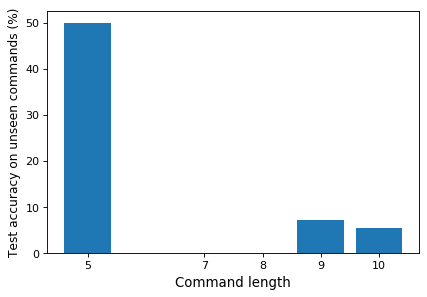

<Figure size 432x288 with 0 Axes>

In [19]:
cmd_lengths, cmd_accs = zip(*results_cmds.items())
plt.figure(figsize=(6, 4), dpi=80)
plt.bar(cmd_lengths, cmd_accs)
plt.xlabel('Command length', fontsize=12)
plt.ylabel('Test accuracy on unseen commands (%)', fontsize=11)
plt.xticks(ticks=cmd_lengths)
plt.savefig('./paper/plots/experiment_2_commands_(GRU_with_attention).png')
plt.show()
plt.clf()

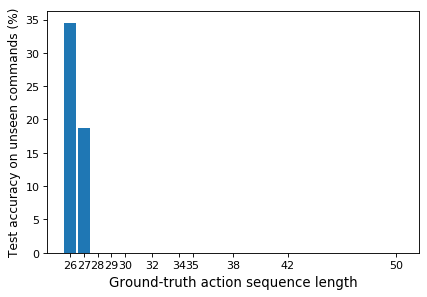

<Figure size 432x288 with 0 Axes>

In [20]:
act_lengths, act_accs = zip(*results_acts.items())
plt.figure(figsize=(6,4), dpi=80)
plt.bar(act_lengths, act_accs, width=0.9)
plt.xlabel('Ground-truth action sequence length', fontsize=12)
plt.ylabel('Test accuracy on unseen commands (%)', fontsize=11)
plt.xticks(ticks=act_lengths)
plt.savefig('./paper/plots/experiment_2_actions_(GRU_with_attention).png')
plt.show()
plt.clf()

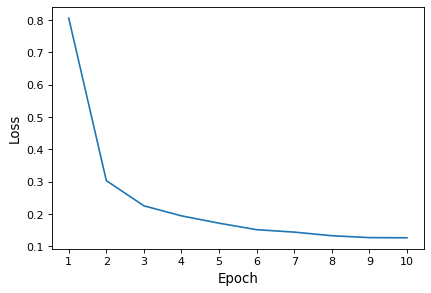

<Figure size 432x288 with 0 Axes>

In [27]:
plt.figure(figsize=(6,4), dpi=80)
plt.plot(range(1, n_epochs+1), train_losses)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(ticks=list(range(1, n_epochs+1)))
plt.show()
plt.clf()

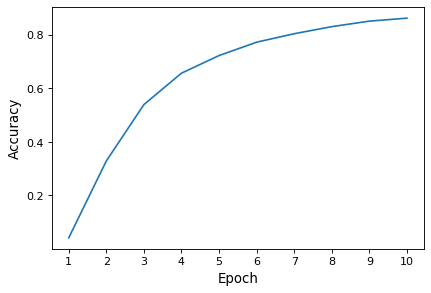

<Figure size 432x288 with 0 Axes>

In [28]:
plt.figure(figsize=(6,4), dpi=80)
plt.plot(range(1, n_epochs+1), train_accs)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(ticks=list(range(1, n_epochs+1)))
plt.show()
plt.clf()